In [73]:
import numpy as np
import locale
import copy
import matplotlib.pyplot as plt
from math import floor, log10, ceil
from scipy import special, optimize
from scipy.integrate import solve_bvp, quad
from scipy.interpolate import make_interp_spline

# Set to German locale to get comma decimal separater
locale.setlocale(locale.LC_NUMERIC, "ru_RU")
plt.rcParams.update({"font.size": 13})
params = {"text.latex.preamble": r"\usepackage{icomma}"}
plt.rcParams["axes.formatter.use_locale"] = True
plt.rcParams.update(params)

props = dict(boxstyle="square", facecolor="white")
props_note = dict(boxstyle="ellipse", facecolor="white")

eV_to_J = 1.6e-19
eV_to_K = 11604
J_to_eV = 6.242e18
eV_to_erg = 1.602e-12
erg_to_eV = 6.242e11
K_to_erg = 1.381e-16
erg_to_K = 7.243e15
Cl_to_SGS = 3.0e9


me = 9.11e-28  # electron mass
mi = 1.67e-24  # ion(proton) mass
e = 1.6e-19 * Cl_to_SGS  # electric charge of electron
a = 120.4 / K_to_erg**2 * Cl_to_SGS  # Richardson's constant
sigma = 5.67e-5 # Stefan-Boltzmann constant
phiout = 4.54 * eV_to_erg  # Pa6oma

nse = 1.0e13 # plasma component density
Te = 200.0 * eV_to_erg  # electron temperature
deltae = 0  # SEE coefficient
cs = np.sqrt(Te / mi)  # Bohm's criterion velocity
# vth = np.sqrt(8 * Te / (np.pi * me))  # Thermal electron velocity

#at T = 3000
rho = 19.079
Cp = 144 * 1.0e7 / 1.0e3
kappa = 118 * 1.0e7 / 1.0e2

r_debye = np.sqrt(Te / (4 * np.pi * nse * e**2))
omega_p = np.sqrt(4 * np.pi * nse * e**2 / me)


def TK(T):  # dimensionless form temperature to [K]
    return T * Te * erg_to_K


def TD(T):  # [K] temperature to dimensionless form
    return T / Te * K_to_erg

In [74]:
def nte_w_func(derw, Tw, Te, nse):
    dA = -np.sign(derw) * np.sqrt(abs(derw)) * np.sqrt(e * Te / r_debye) * 300
    # print(dA * Te * erg_to_eV, phiout * erg_to_eV)
    return (
        a
        * (Tw * Te) ** 2.0
        * np.exp(-(phiout / Te + dA) / Tw)
        / (0.25 * e * nse * np.sqrt(Tw * Te * 8.0 / np.pi / me))
    )


def upsilon_0_func(phi_se):
    return np.sqrt(-2.0 * phi_se) if (phi_se < 0) else 0.0


def erfcxexp_limit_resolve(x):
    if x > 200:
        return (
            np.power(x, -0.5)
            - np.power(x, -1.5) / 2.0
            + np.power(x, -2.5) * 3.0/4.0
            - np.power(x, -3.5) * 15.0/8.0
            + np.power(x, -4.5) * 105.0/16.0
        ) / np.sqrt(np.pi)
    else:
        return special.erfc(np.sqrt(x))*np.exp(x)

In [91]:
def Poisson_integrated_classic_trans(phi, y, args):
    V_f, n_e, Tw = y
    nse, nte_w, upsilon_0, phi_se = args
    return (
        upsilon_0 * np.sqrt(upsilon_0**2 - 2 * (phi - phi_se))
        + n_e * np.exp(phi - phi_se)
        + nte_w
        * Tw
        * (
            erfcxexp_limit_resolve((phi - (V_f + phi_se)) / Tw)
            + 2 / np.sqrt(np.pi) * np.sqrt((phi - (phi_se + V_f)) / Tw)
        )
    )


def Poisson_classic_trans(y, args):
    V_f, n_e, Tw = y
    nse, nte_w, upsilon_0, phi_se = args
    return -2.0 * (
        Poisson_integrated_classic_trans(phi_se + V_f, y, args)
        - Poisson_integrated_classic_trans(phi_se, y, args)
    )


def quasineutrality_trans(y, args):
    V_f, n_e, Tw = y
    nse, nte_w, upsilon_0, phi_se = args
    return 1 - nte_w * erfcxexp_limit_resolve(-V_f / Tw) - n_e


def j_wall_trans(y, args):
    V_f, n_e, Tw = y
    nse, nte_w, upsilon_0, phi_se = args
    return V_f - np.log(
        4 * upsilon_0 / (n_e * np.sqrt(8 * mi / (np.pi * me)))
        + nte_w / n_e * np.sqrt(Tw)
    )



def sys_trans(y, *args):
    V_f, n_e, Tw = y
    Te, nse, phi_se = args
    args1 = [nse, nte_w_func(0, Tw, Te, nse), upsilon_0_func(phi_se), phi_se]
    return [
        # Bohm_criterion_trans(y, args1),
        Poisson_classic_trans(y, args1),
        j_wall_trans(y, args1),
        quasineutrality_trans(y, args1),
    ]

def phi_se_func(_base, _amp, _omega, _t):
    # return _base + np.heaviside(1 - _t / (2 * np.pi / _omega), 0)*(-_amp + _amp / 10 * np.sin(_omega * 5 * _t))
    return _base + _amp * np.sin(_omega * _t)

amp = 0.4
omega = 2 * np.pi * 2.0e6 / omega_p
print(2 * np.pi / omega)
base = -0.5
t_net_max = 1 * 1.0e-6 / (1 / omega_p)
t_net_steps = 1001
t_net = np.linspace(0, t_net_max, t_net_steps)
sol_trans_init_guesses = [
    [-1.1866, 0.892, TD(3165)],
    [-1.1866, 0.892, TD(2900)],
    [-1.15, 0.9, TD(2750)],
    [-1.0, 0.9, TD(3200)],
    [-3.7, 0.999, TD(2700)]
]

V_f_trans_osc_net = np.zeros(t_net_steps)
n_e_trans_osc_net = np.zeros(t_net_steps)
Tw_trans_osc_net = np.zeros(t_net_steps)

for i in range(t_net_steps):
    sw_trans = False
    args_trans = (Te, nse, phi_se_func(base, amp, omega, t_net[i]))
    for j in range(len(sol_trans_init_guesses)):
        sol_trans = optimize.fsolve(sys_trans, sol_trans_init_guesses[j], args=args_trans)
        if (np.isclose(sys_trans(sol_trans, *args_trans), np.zeros(len(sol_trans))) == np.ones(len(sol_trans), dtype = bool)).all():
            sw_trans = True
            break
        else:
            print(sys_trans(sol_trans, *args_trans))
    if sw_trans == False:
        raise NameError('Appropriate sol_trans not found. Add more initial guesses')
    else:
        V_f_trans_osc_net[i], n_e_trans_osc_net[i], Tw_trans_osc_net[i] = sol_trans

89136.78898323892


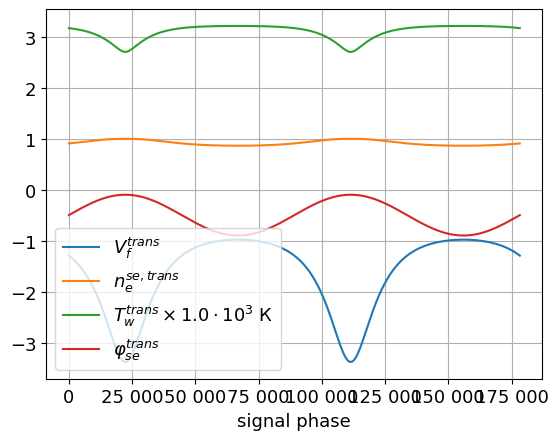

2700.7258475708063
-3.378433544672269
0.9975949614963081


In [92]:
plt.plot(t_net, V_f_trans_osc_net, label = r'$V_f^{trans}$')
plt.plot(t_net, n_e_trans_osc_net, label = r'$n_e^{se, trans}$')
plt.plot(t_net, TK(Tw_trans_osc_net) / np.full_like(Tw_trans_osc_net, 1.0e3), label = r'$T_w^{trans} \times 1.0\cdot10^3$ К')
plt.plot(t_net, phi_se_func(base, amp, omega, t_net), label = r'$\varphi_{se}^{trans}$')
plt.legend()
plt.xlabel(r"signal phase")
plt.grid()
plt.show()
print(min(TK(Tw_trans_osc_net)))
print(min(V_f_trans_osc_net))
print(max(n_e_trans_osc_net))

In [77]:
def j_wall_classic(y, args):
    derw, n_e, V_f = y
    Tw, nte_w, upsilon_0, phi_se = args
    return V_f - np.log(
        4 * upsilon_0 / (n_e * np.sqrt(8 * mi / (np.pi * me)))
        + nte_w / n_e * np.sqrt(Tw)
    )

def Bohm_criterion_classic(y, args):
    derw, n_e, V_f = y
    Tw, nte_w, upsilon_0, phi_se = args
    return phi_se + 0.5 * Tw / (
        n_e * Tw
        + nte_w
        * (
            erfcxexp_limit_resolve(-V_f / Tw)
            - 1 / (np.sqrt(np.pi) * np.sqrt(-V_f / Tw))
        )
    )


def quasineutrality_classic(y, args):
    derw, n_e, V_f = y
    Tw, nte_w, upsilon_0, phi_se = args
    return 1 - nte_w * erfcxexp_limit_resolve(-V_f / Tw) - n_e


def Poisson_integrated_classic(phi, y, args):
    derw, n_e, V_f = y
    Tw, nte_w, upsilon_0, phi_se = args
    return (
        upsilon_0**2 * np.sqrt(1 - 2 * (phi - phi_se) / upsilon_0**2)
        + n_e * np.exp(phi - phi_se)
        + nte_w
        * Tw
        * (
            erfcxexp_limit_resolve((phi - (V_f + phi_se)) / Tw)
            + 2 / np.sqrt(np.pi) * np.sqrt((phi - (phi_se + V_f)) / Tw)
        )
    )


def Poisson_classic(y, args):
    derw, n_e, V_f = y
    Tw, nte_w, upsilon_0, phi_se = args
    return derw**2 - 2.0 * (
        Poisson_integrated_classic(phi_se + V_f, y, args)
        - Poisson_integrated_classic(phi_se, y, args)
    )


def sys_classic(y, *args):
    derw, n_e, V_f = y
    Tw, Te, nse, phi_se = args
    args1 = [Tw, nte_w_func(derw, Tw, Te, nse), upsilon_0_func(phi_se), phi_se]
    return [
        # Bohm_criterion_classic(y, args1),
        quasineutrality_classic(y, args1),
        j_wall_classic(y, args1),
        Poisson_classic(y, args1)
    ]

In [78]:
def jwall_SCL(y, args):
    derw, n_e_se, V_f, V_vc = y
    Tw, nte_w, upsilon_0, phi_se = args
    dip = (V_f - V_vc) / Tw
    return (
        upsilon_0
        - 0.25 * n_e_se * np.sqrt(8 * mi / (np.pi * me)) * np.exp(V_vc)
        + 0.25 * nte_w * np.sqrt(Tw * 8 * mi / (np.pi * me)) * np.exp(-dip)
    )  #


def quasineutrality_SCL(y, args):
    derw, n_e_se, V_f, V_vc = y
    Tw, nte_w, upsilon_0, phi_se = args
    dip = (V_f - V_vc) / Tw
    return (
        1 - n_e_se - nte_w * erfcxexp_limit_resolve(-V_vc / Tw) * np.exp(-dip)
    )  #


def Poisson_integrated_SCL_beta(phi, y, args):
    derw, n_e_se, V_f, V_vc = y
    Tw, nte_w, upsilon_0, phi_se = args
    dip = (V_f - V_vc) / Tw
    return (
        upsilon_0**2 * np.sqrt(1 - 2 * (phi - phi_se) / upsilon_0**2)
        + n_e_se * np.exp(phi - phi_se)
        + nte_w
        * Tw
        * np.exp(-dip)
        * (
            erfcxexp_limit_resolve((phi - (V_vc + phi_se)) / Tw)
            + 2.0
            / np.sqrt(np.pi)
            * np.sqrt((phi - (V_vc + phi_se)) / Tw)
        )
    )  # ~~~


def Poisson_SCL_beta(y, args):
    derw, n_e_se, V_f, V_vc = y
    Tw, nte_w, upsilon_0, phi_se = args
    return -2 * (
        Poisson_integrated_SCL_beta(V_vc + phi_se, y, args)
        - Poisson_integrated_SCL_beta(phi_se, y, args)
    )

def Poisson_integrated_SCL_alpha(phi, y, args):
    derw, n_e_se, V_f, V_vc = y
    Tw, nte_w, upsilon_0, phi_se = args
    dip = (V_f - V_vc) / Tw
    res = (
        upsilon_0**2 * np.sqrt(1 - 2 * (phi - phi_se) / upsilon_0**2)
        + n_e_se
        * (
            # np.exp(V_vc) * erfcxexp_limit_resolve(phi - (V_vc + phi_se))
            np.exp(phi - phi_se) * special.erfc(np.sqrt(phi - (V_vc + phi_se)))
            + 2.0
            / np.sqrt(np.pi)
            * (np.sqrt(phi - (V_vc + phi_se)))
            * np.exp(V_vc)
        )
        + nte_w
        * Tw
        * (
            np.exp((phi - (V_f + phi_se))/Tw) * (1 + special.erf(np.sqrt((phi - (V_vc + phi_se)) / Tw)))
            - 2.0
            / np.sqrt(np.pi)
            * (np.sqrt((phi - (V_vc + phi_se))/Tw))
            * np.exp((V_vc - V_f)/Tw)
        )
    )
    return res

def Poisson_SCL_alpha(y, args):
    derw, n_e_se, V_f, V_vc = y
    Tw, nte_w, upsilon_0, phi_se = args
    return derw**2 - 2 * (
        Poisson_integrated_SCL_alpha(V_f + phi_se, y, args)
        - Poisson_integrated_SCL_alpha(V_vc + phi_se, y, args)
    )


def sys_SCL(y, *args):
    derw, n_e_se, V_f, V_vc = y
    Tw, Te, nse, phi_se = args
    nte_w = nte_w_func(derw, Tw, Te, nse)
    upsilon_0 = upsilon_0_func(phi_se)
    args1 = [Tw, nte_w, upsilon_0, phi_se]
    return [
        quasineutrality_SCL(y, args1),
        jwall_SCL(y, args1),
        Poisson_SCL_alpha(y, args1),
        Poisson_SCL_beta(y, args1),
    ]


In [79]:
V_f_osc_net = np.zeros(t_net_steps)
V_vc_osc_net = np.zeros(t_net_steps)
n_e_osc_net = np.zeros(t_net_steps)
derw_osc_net = np.zeros(t_net_steps)
Tw_base = TD(3150)

sw_prev_was_classic = True
for i in range(t_net_steps):
	Tw = Tw_base
	args = (Tw, Te, nse, phi_se_func(base, amp, omega, t_net[i]))
	if (Tw < Tw_trans_osc_net[i]):
		sol = optimize.fsolve(sys_classic, [1.0, 0.9, -1.0], args=args)
		derw_osc_net[i] = sol[0]
		n_e_osc_net[i] = sol[1]
		V_f_osc_net[i] = sol[2]
		V_vc_osc_net[i] = sol[2]
		if not (np.isclose(sys_classic(sol, *args), np.zeros(len(sol))) == np.ones(len(sol), dtype = bool)).all():
			print(f"{t_net[i]:.2f}", " : ", sys_classic(sol, *args))
		sw_prev_was_classic = True
	else:
		if (sw_prev_was_classic == False):
			sol = np.ones((4, 1))
			sol = optimize.fsolve(sys_SCL, [
				derw_osc_net[i - 1],
				n_e_osc_net[i - 1],
				V_f_osc_net[i - 1],
				V_vc_osc_net[i - 1],
			], args=args)
		elif (sw_prev_was_classic == True):
			sw_prev_was_classic = False
			j = 0
			sol = np.ones((4, 1))
			while (not (np.less(sys_SCL(sol, *args), np.full(len(sol), 1.0e-7)) == np.ones(len(sol), dtype = bool)).all()) and j < 30:
			# while(not (np.isclose(sys_SCL(sol, *args), np.zeros(len(sol))) == np.ones(len(sol), dtype = bool)).all()) and j < 20:
				sol = optimize.fsolve(sys_SCL, [
					0 - 0.002 * j, # 0.001
					n_e_trans_osc_net[i],
					V_f_trans_osc_net[i] + 0.00001 * j,
					V_f_trans_osc_net[i]
				], args=args)
				j += 1
		derw_osc_net[i] = -abs(sol[0])
		n_e_osc_net[i] = sol[1]
		V_f_osc_net[i] = sol[2]
		V_vc_osc_net[i] = sol[3]
		# if not (np.isclose(sys_SCL(sol, *args), np.zeros(len(sol))) == np.ones(len(sol), dtype = bool)).all():
		# 	print(f"{t_net[i]:.2f}", " : ", sys_SCL(sol, *args))
		# 	True

C:\Users\popac\AppData\Local\Temp\ipykernel_2684\240181665.py:26: RuntimeWarning: invalid value encountered in sqrt
  return special.erfc(np.sqrt(x))*np.exp(x)
C:\Users\popac\AppData\Local\Temp\ipykernel_2684\1944162232.py:53: RuntimeWarning: invalid value encountered in sqrt
  upsilon_0**2 * np.sqrt(1 - 2 * (phi - phi_se) / upsilon_0**2)
C:\Users\popac\AppData\Local\Temp\ipykernel_2684\1944162232.py:35: RuntimeWarning: invalid value encountered in sqrt
  * np.sqrt((phi - (V_vc + phi_se)) / Tw)
C:\Users\popac\AppData\Local\Temp\ipykernel_2684\1944162232.py:57: RuntimeWarning: invalid value encountered in sqrt
  np.exp(phi - phi_se) * special.erfc(np.sqrt(phi - (V_vc + phi_se)))
C:\Users\popac\AppData\Local\Temp\ipykernel_2684\1944162232.py:60: RuntimeWarning: invalid value encountered in sqrt
  * (np.sqrt(phi - (V_vc + phi_se)))
C:\Users\popac\AppData\Local\Temp\ipykernel_2684\1944162232.py:66: RuntimeWarning: invalid value encountered in sqrt
  np.exp((phi - (V_f + phi_se))/Tw) * (1 +

In [80]:
plt.plot(t_net, V_f_osc_net, label = r'$V_f$')
plt.plot(t_net, V_vc_osc_net, label = r'$V_{vc}$', linestyle = "--")
plt.plot(t_net, n_e_osc_net, label = r'$n_e$')
plt.plot(t_net, derw_osc_net, label = r"$\varphi^'(x = 0)$")
plt.plot(t_net, phi_se_func(base, amp, omega, t_net), label = r'$\varphi_{se}$')
plt.legend()
plt.title(r'$T_w^{base} = %0.0f$ К	'
	r"$n_i^{se} = %.1f\cdot10^{%d}$ см$^{-3}$   "
    r"$T_e = %0.f$ эВ   "
    % (TK(Tw_base), nse / 10 ** floor(log10(nse)), floor(log10(nse)), Te * erg_to_eV),
	y = -0.2)
plt.grid()
plt.close()
plt.show()

In [81]:
def q_ion_func(y, Tw_net, Tw_trans, is_MW = False):
    derw_net, V_f_net, phi_se_net, n_e_net, V_vc_net = y
    q_net = np.zeros(len(Tw_net))
    for i in range(len(Tw_net)):
        upsilon_0 = upsilon_0_func(phi_se_net[i])
        vth = np.sqrt(8 * mi / (np.pi * me))
        vteth = np.sqrt(8 * Tw_net[i] * mi / (np.pi * me))
        q_net[i] = upsilon_0 * (upsilon_0**2 / 2)
        if (is_MW == True) :
            q_net[i] = q_net[i] * nse * cs * Te * 1.0e6 * 1.0e-2 * 1.0e-7 * 1.0e-6
    return q_net

def q_e_func(y, Tw_net, Tw_trans, is_MW = False):
    derw_net, V_f_net, phi_se_net, n_e_net, V_vc_net = y
    q_net = np.zeros(len(Tw_net))
    for i in range(len(Tw_net)):
        upsilon_0 = upsilon_0_func(phi_se_net[i])
        vth = np.sqrt(8 * mi / (np.pi * me))
        vteth = np.sqrt(8 * Tw_net[i] * mi / (np.pi * me))
        if (Tw_net[i] <= Tw_trans[i]):
            q_net[i] = (
                0.25 * n_e_net[i] * vth * (2 - V_f_net[i] - phi_se_net[i]) * np.exp(V_f_net[i])
            )
        else:
            q_net[i] = (
                0.25 * n_e_net[i] * vth * (2 - V_f_net[i] - phi_se_net[i]) * np.exp(V_vc_net[i])
            )
        if (is_MW == True) :
            q_net[i] = q_net[i] * nse * cs * Te * 1.0e6 * 1.0e-2 * 1.0e-7 * 1.0e-6
    return q_net

def q_te_func(y, Tw_net, Tw_trans, is_MW = False):
    derw_net, V_f_net, phi_se_net, n_e_net, V_vc_net = y
    q_net = np.zeros(len(Tw_net))
    for i in range(len(Tw_net)):
        upsilon_0 = upsilon_0_func(phi_se_net[i])
        vth = np.sqrt(8 * mi / (np.pi * me))
        vteth = np.sqrt(8 * Tw_net[i] * mi / (np.pi * me))
        if (Tw_net[i] <= Tw_trans[i]):
            q_net[i] = (
                - 0.25 * nte_w_func(derw_net[i], Tw_net[i], Te, nse) * vteth * 2 * Tw_net[i]
            )
        else:
            q_net[i] = (
                - 0.25 * nte_w_func(derw_net[i], Tw_net[i], Te, nse) * vteth * 2 * Tw_net[i] * np.exp((V_vc_net[i] - V_f_net[i]) / Tw_net[i])
            )
        if (is_MW == True) :
            q_net[i] = q_net[i] * nse * cs * Te * 1.0e6 * 1.0e-2 * 1.0e-7 * 1.0e-6
    return q_net

def q_bb_func(y, Tw_net, Tw_trans, is_MW = False):
    derw_net, V_f_net, phi_se_net, n_e_net, V_vc_net = y
    q_net = np.zeros(len(Tw_net))
    for i in range(len(Tw_net)):
        upsilon_0 = upsilon_0_func(phi_se_net[i])
        vth = np.sqrt(8 * mi / (np.pi * me))
        vteth = np.sqrt(8 * Tw_net[i] * mi / (np.pi * me))
        q_net[i] = -sigma * (Tw_net[i]*Te)**4 / (nse * cs * Te)
        if (is_MW == True) :
            q_net[i] = q_net[i] * nse * cs * Te * 1.0e6 * 1.0e-2 * 1.0e-7 * 1.0e-6
    return q_net

is_MW = False
q_te_net = q_te_func([derw_osc_net, V_f_osc_net, phi_se_func(base, amp, omega, t_net), n_e_osc_net, V_vc_osc_net], np.full_like(t_net, Tw_base), Tw_trans_osc_net, is_MW)
q_e_net = q_e_func([derw_osc_net, V_f_osc_net, phi_se_func(base, amp, omega, t_net), n_e_osc_net, V_vc_osc_net], np.full_like(t_net, Tw_base), Tw_trans_osc_net, is_MW)
q_ion_net = q_ion_func([derw_osc_net, V_f_osc_net, phi_se_func(base, amp, omega, t_net), n_e_osc_net, V_vc_osc_net], np.full_like(t_net, Tw_base), Tw_trans_osc_net, is_MW)
q_bb_net = q_bb_func(([derw_osc_net, V_f_osc_net, phi_se_func(base, amp, omega, t_net), n_e_osc_net, V_vc_osc_net]), np.full_like(t_net, Tw_base), Tw_trans_osc_net, is_MW)
q_net = q_te_net + q_e_net + q_ion_net + q_bb_net


In [82]:
fig = plt.figure(figsize = (9, 6), dpi = 300)

plt.plot(t_net, q_net, lw = 3, color = 'k', label = r"Суммарный")
plt.plot(t_net, q_ion_net, lw = 2, label = r"Ионный")
plt.plot(t_net, q_e_net, lw = 2, label = r"Электронный")
plt.plot(t_net, q_te_net, lw = 2, label = r"Термоэлектронная эмиссия")
plt.plot(t_net, q_bb_net, lw = 2, linestyle = "-.", label = r"Излучение абс.черного тела")
plt.grid()
plt.ylim(-0.5, max(q_net) + 2.0)
plt.legend()
plt.ylabel(r'$q_{w}$')
plt.xlabel(r'signal phase')
plt.title(r'$T_w^{base} = %0.0f$ К	'
	r"$n_i^{se} = %.1f\cdot10^{%d}$ см$^{-3}$   "
    r"$T_e = %0.f$ эВ   "
    % (TK(Tw_base), nse / 10 ** floor(log10(nse)), floor(log10(nse)), Te * erg_to_eV),
	y = -0.2)
plt.close()
plt.show()

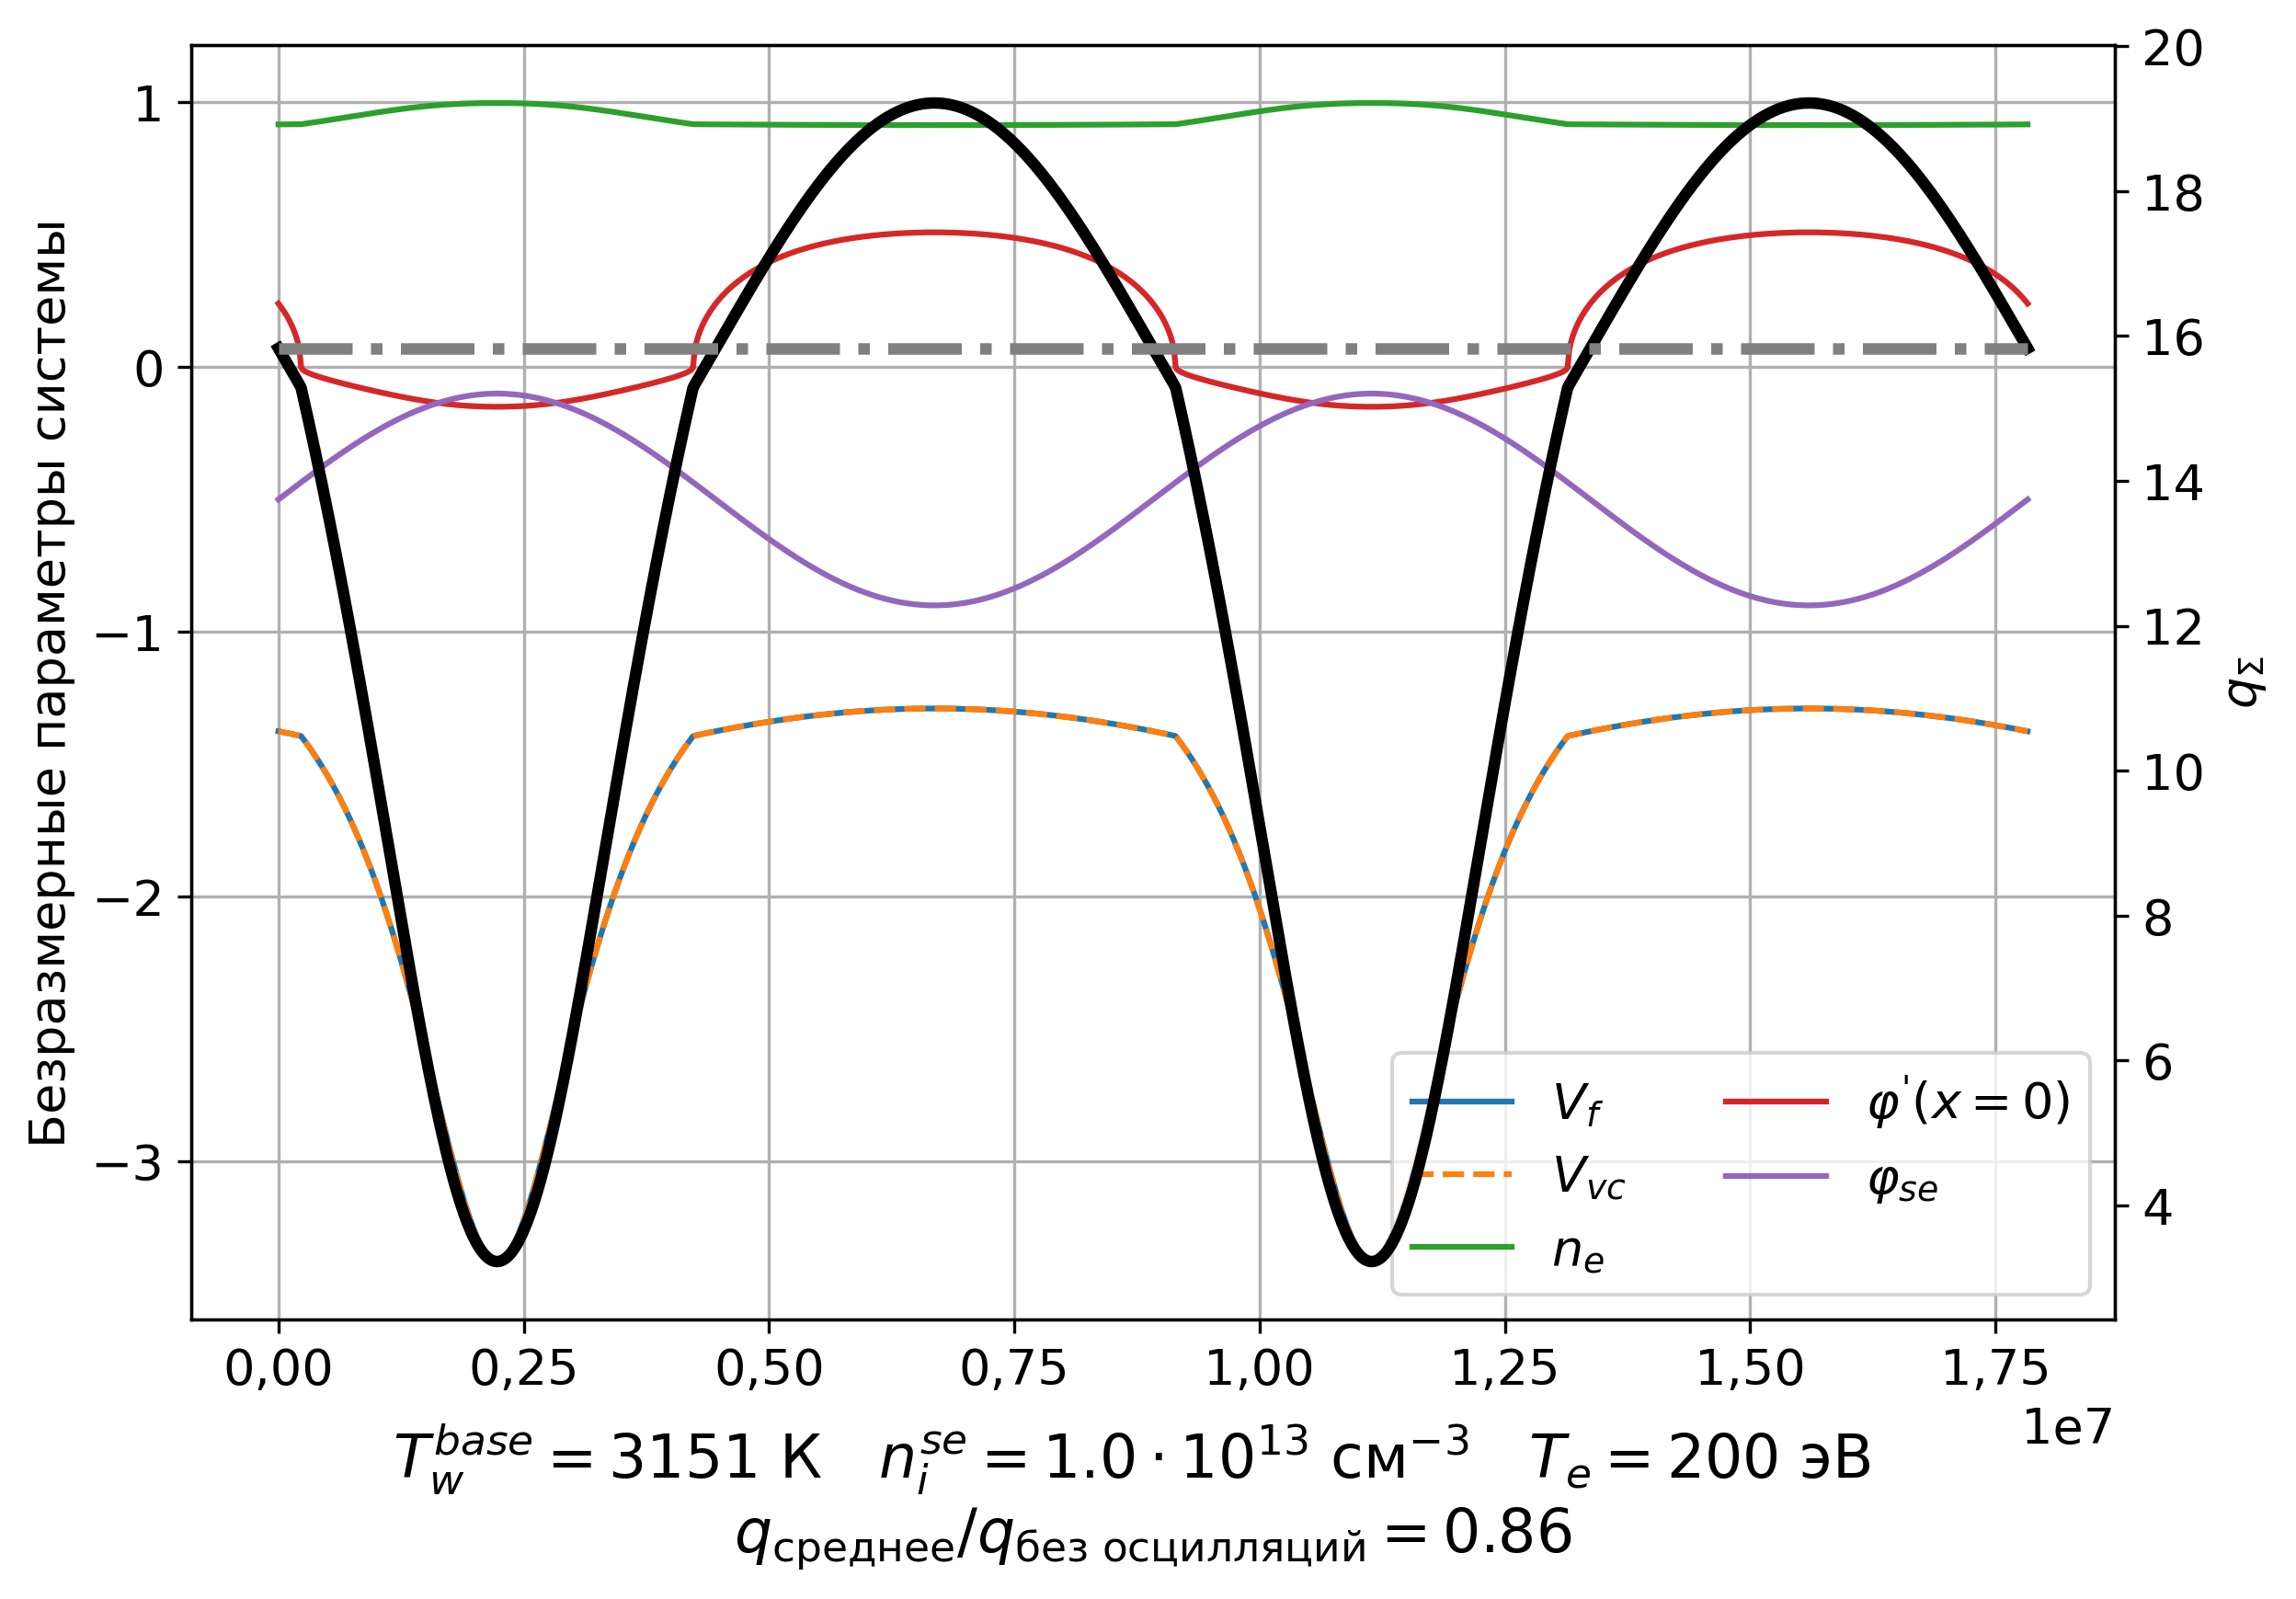

In [90]:
fig, ax1 = plt.subplots(figsize = (9, 6), dpi = 300)
ax2 = ax1.twinx()
ax1.plot(t_net, V_f_osc_net, label = r'$V_f$')
ax1.plot(t_net, V_vc_osc_net, label = r'$V_{vc}$', linestyle = "--")
ax1.plot(t_net, n_e_osc_net, label = r'$n_e$')
ax1.plot(t_net, derw_osc_net, label = r"$\varphi^'(x = 0)$")
ax2.plot(t_net, q_net, lw = 3, color = 'k', label = r"$\Sigma$ $q_w$")
ax1.plot(t_net, phi_se_func(base, amp, omega, t_net), label = r'$\varphi_{se}$')
# ax2.plot(t_net, np.full_like(t_net, np.sum(q_net) / np.shape(t_net)[0]), lw = 3, color = 'k', linestyle = 'dashed')
ax2.plot(t_net, np.full_like(t_net, q_net[0]), lw = 3, color = 'grey', linestyle = '-.')
# ax1.set_ylabel(r"$V_f$, $V_{vc}$, $n_e^{se}$, $\varphi^'(x = 0)$, $\varphi_{se}$")
ax1.set_ylabel(r"Безразмерные параметры системы")
ax2.set_ylabel(r"$q_\Sigma$")
ax1.legend(ncols = 2)
plt.title(r'$T_w^{base} = %0.0f$ К	'
	r"$n_i^{se} = %.1f\cdot10^{%d}$ см$^{-3}$   "
    r"$T_e = %0.f$ эВ   "
    "\n"
    r"$q_{\text{среднее}}/q_{\text{без осцилляций}} = %.2f$"
    % (TK(Tw_base), nse / 10 ** floor(log10(nse)), floor(log10(nse)), Te * erg_to_eV, sum(q_net)/q_net[0]/len(q_net)),
	y = -0.2)
ax1.grid()
# plt.close()

In [101]:
def q_response_func(y, Tw_trans):
    derw, n_e, V_f, V_vc, phi_se, Tw = y
    derw = np.full(1, derw)
    n_e = np.full(1, n_e)
    V_f = np.full(1, V_f)
    V_vc = np.full(1, V_vc)
    phi_se = np.full(1, phi_se)
    Tw = np.full(1, Tw)
    is_MW = False
    res = 0
    res += q_ion_func(
        [derw, V_f, phi_se, n_e, V_vc], np.full(1, Tw), np.full(1, Tw_trans), is_MW
    )
    res += q_e_func(
        [derw, V_f, phi_se, n_e, V_vc], np.full(1, Tw), np.full(1, Tw_trans), is_MW
    )
    # res += q_te_func([derw, V_f, phi_se, n_e, V_vc], np.full(1, Tw), np.full(1, Tw_trans), is_MW)
    # res += q_bb_func([derw, V_f, phi_se, n_e, V_vc], np.full(1, Tw), np.full(1, Tw_trans), is_MW)
    if phi_se == -0.1:
        return 0
    return res * nse * cs * Te


def heat_equation_solution(T_init, t_net, heat_signal):
    if len(t_net) == 1:
        return T_init
    k_value = 3 if len(t_net) >= 4 else len(t_net) - 1
    heat_signal_spline = make_interp_spline(t_net, heat_signal, k=k_value)
    res = quad(
        lambda tau: heat_signal_spline(tau) / np.sqrt(t_net[-1] - tau), 0, t_net[-1]
    )
    return T_init + TD(
        1
        / np.sqrt(np.pi * rho * Cp * kappa)
        * res[0]
        * np.sqrt(2 * np.pi / np.sqrt(4 * np.pi * nse * e**2 / me))
    )

T_init = TD(3100)
print(TK(T_init))
Tw_response = T_init
log_response = np.zeros((7, t_net_steps))
sw_prev_was_classic = True
for i in range(t_net_steps):
    log_response[5, i] = Tw_response
    args = (Tw_response, Te, nse, phi_se_func(base, amp, omega, t_net[i]))
    if Tw_response < Tw_trans_osc_net[i]:
        sol = optimize.fsolve(sys_classic, [1.0, 0.9, -1.0], args=args)
        log_response[0:3, i] = sol
        log_response[3, i] = sol[2]
        sw_prev_was_classic = True
    else:
        # if not sw_prev_was_classic:
        #     sol = optimize.fsolve(sys_SCL, log_response[0:4, i - 1], args=args)
        # else:
        j = 0
        sol = np.ones((4, 1))
        while (
            not (
                np.less(sys_SCL(sol, *args), np.full(len(sol), 1.0e-7))
                == np.ones(len(sol), dtype=bool)
            ).all()
        ) and j < 30:
            sol = optimize.fsolve(
                sys_SCL,
                [
                    0 - 0.1 * j,  # 0.001
                    n_e_trans_osc_net[i],
                    V_f_trans_osc_net[i] + 0.00001 * j,
                    V_f_trans_osc_net[i],
                ],
                args=args,
            )
            j += 1
        sw_prev_was_classic = False
        log_response[0:4, i] = sol
        log_response[0, i] = -abs(sol[0])

    log_response[4, i] = args[3]
    log_response[6, i] = q_response_func(log_response[0:6, i], Tw_trans_osc_net[i])
    Tw_response = heat_equation_solution(
        T_init, t_net[0 : i + 1], log_response[6, 0 : i + 1]
    )

3100.80073


C:\Users\popac\AppData\Local\Temp\ipykernel_2684\2255675423.py:80: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  log_response[6, i] = q_response_func(log_response[0:6, i], Tw_trans_osc_net[i])
C:\Users\popac\AppData\Local\Temp\ipykernel_2684\240181665.py:26: RuntimeWarning: invalid value encountered in sqrt
  return special.erfc(np.sqrt(x))*np.exp(x)
C:\Users\popac\AppData\Local\Temp\ipykernel_2684\1944162232.py:53: RuntimeWarning: invalid value encountered in sqrt
  upsilon_0**2 * np.sqrt(1 - 2 * (phi - phi_se) / upsilon_0**2)
C:\Users\popac\AppData\Local\Temp\ipykernel_2684\1944162232.py:35: RuntimeWarning: invalid value encountered in sqrt
  * np.sqrt((phi - (V_vc + phi_se)) / Tw)
C:\Users\popac\AppData\Local\Temp\ipykernel_2684\1944162232.py:57: RuntimeWarning: invalid value encountered in sqrt
  np.exp(phi 

11.251086980900137
2
1.0073818683455127
0.8876191675592844


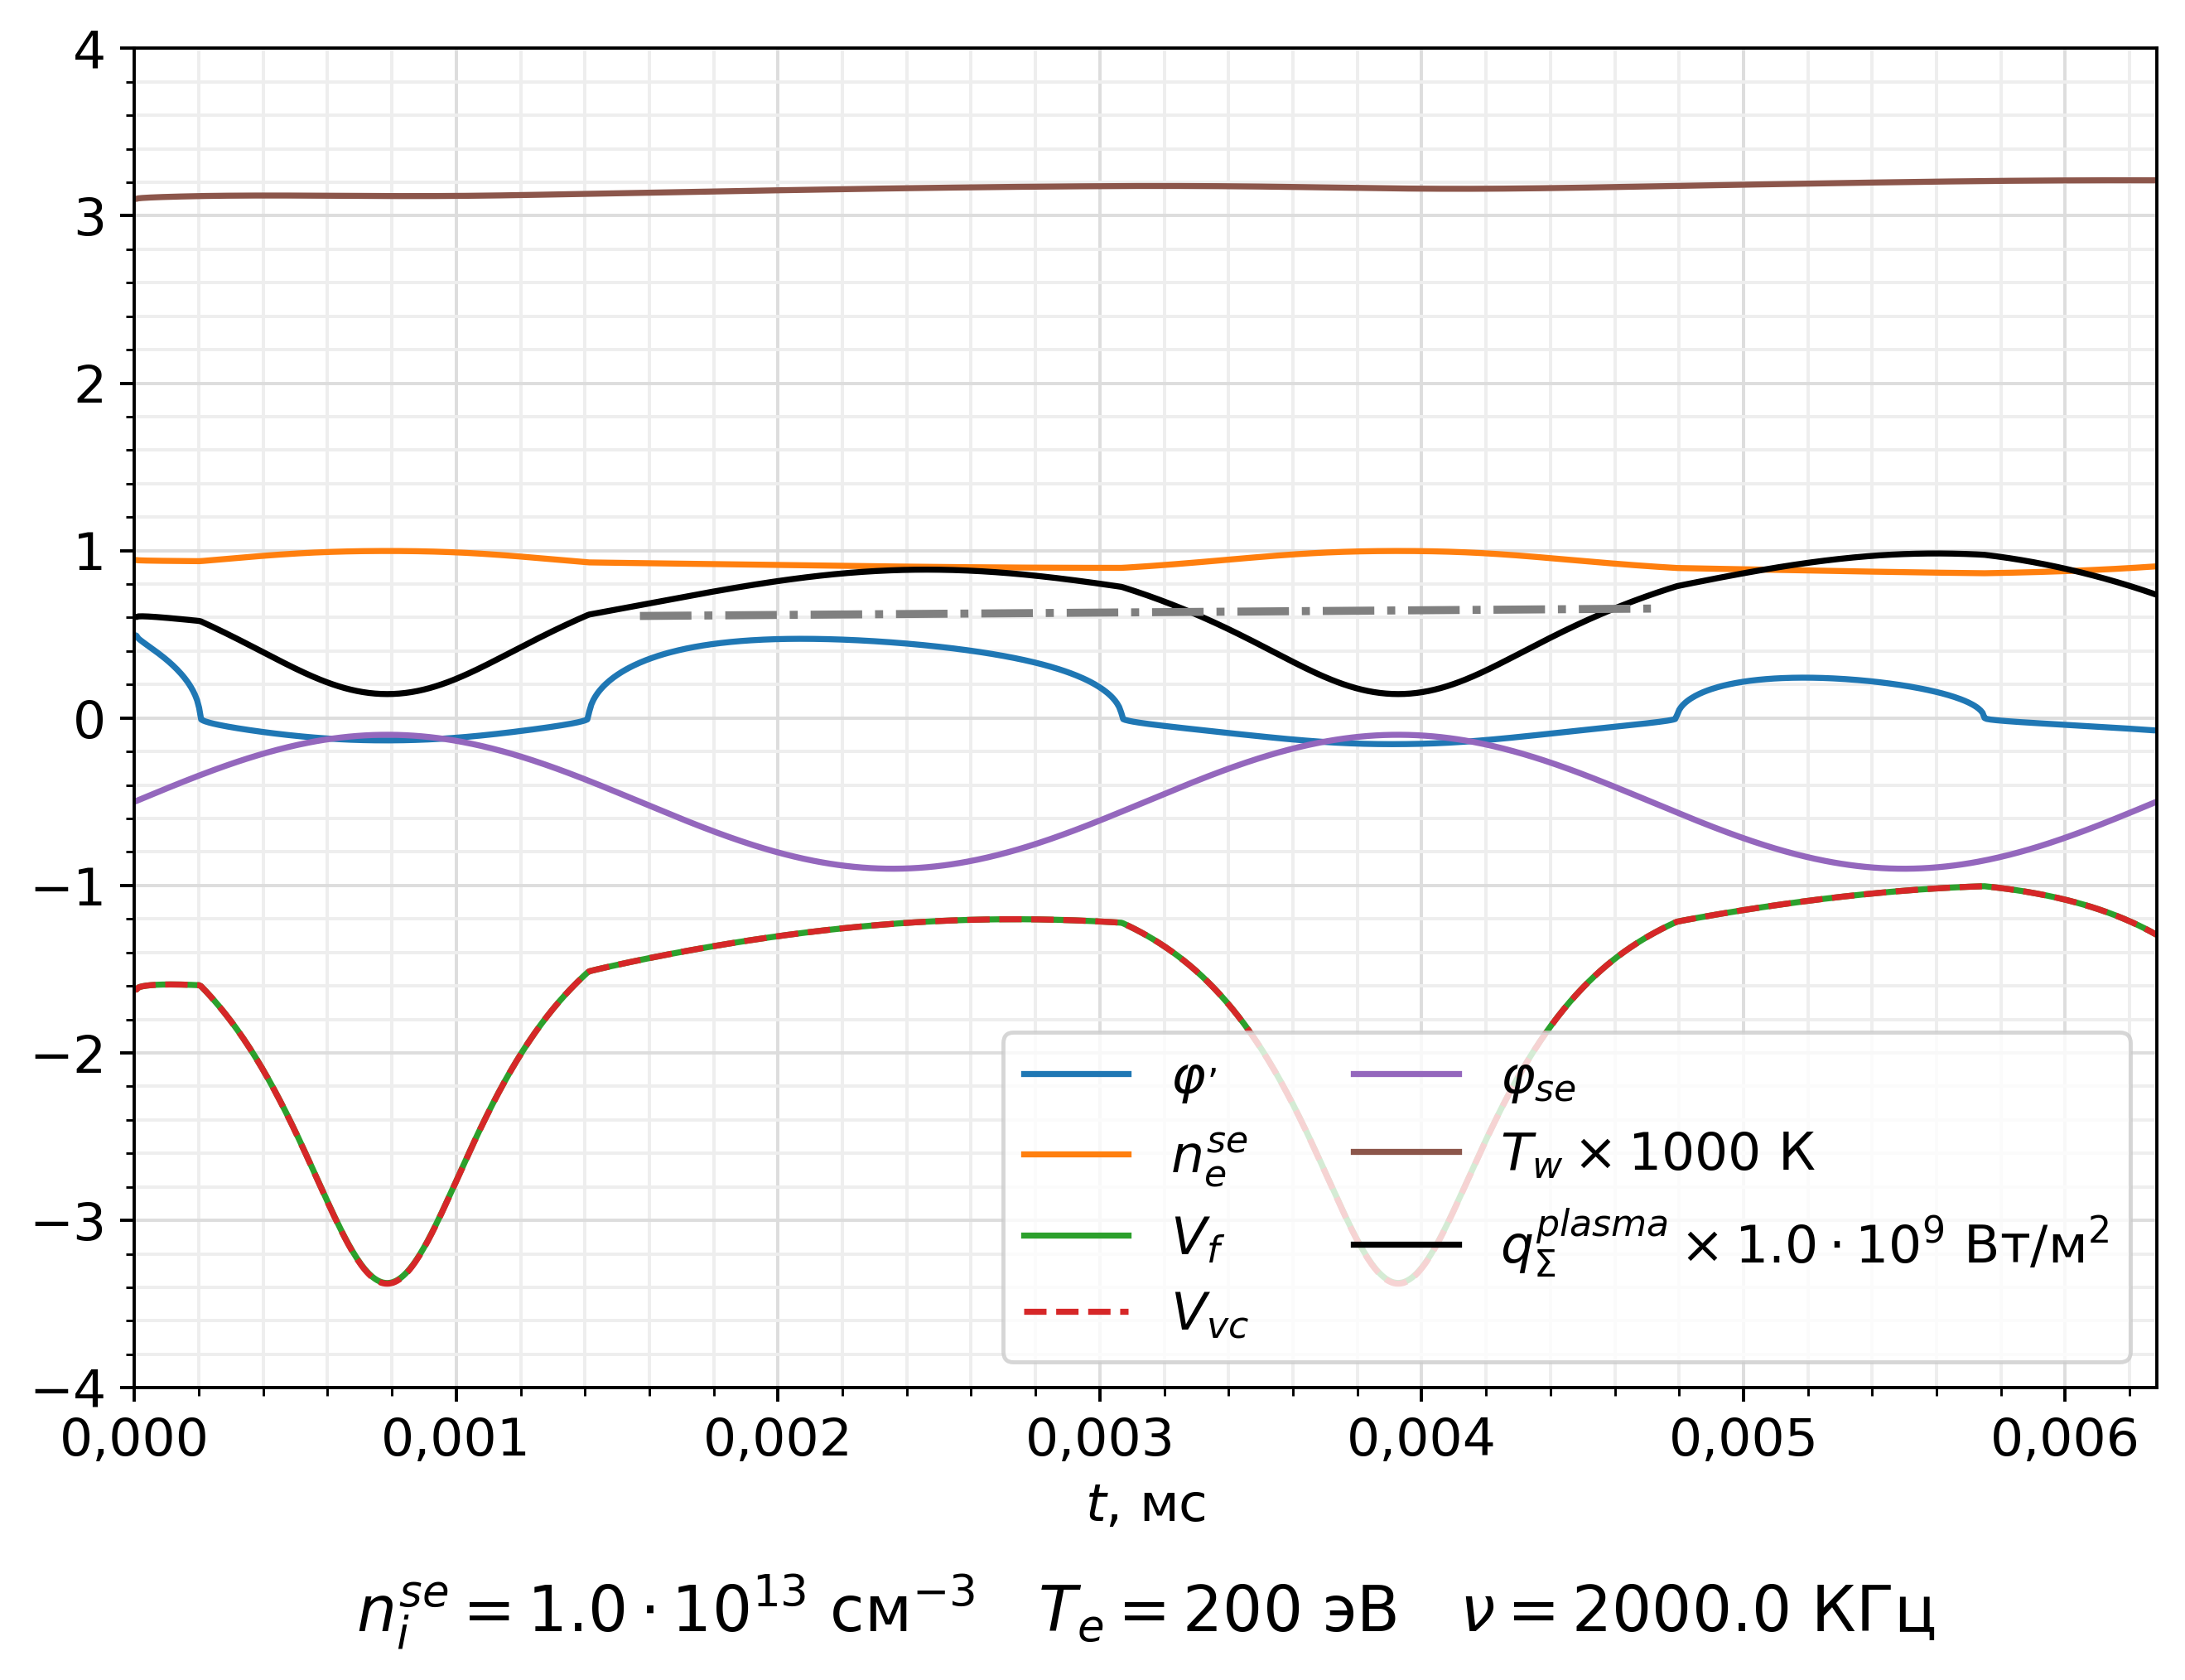

In [102]:
fig = plt.figure(figsize=(9, 6), dpi=350)

print(np.log10(np.sqrt(4 * np.pi * nse * e**2 / me)))

t_net_plot = t_net * np.full_like(
    t_net, 2 * np.pi / omega_p * 1.0e3
)
q_dless = log_response[6, :] * np.full_like(log_response[6, :], 1.0e-7 * 1.0e4 * 1.0e-9)
plt.plot(t_net_plot, log_response[0, :], label = r"$\varphi^,$")
plt.plot(t_net_plot, log_response[1, :], label=r"$n_e^{se}$")
plt.plot(t_net_plot, log_response[2, :], label=r"$V_f$")
plt.plot(t_net_plot, log_response[3, :], linestyle="--", label=r"$V_{vc}$")
plt.plot(t_net_plot, log_response[4, :], label=r"$\varphi_{se}$")
plt.plot(t_net_plot, TK(log_response[5, :]) / 1000, label=r"$T_w\times1000$ К")
plt.plot(t_net_plot, q_dless, c = 'k', label = r"$q_\Sigma^{plasma}\times1.0\cdot10^9$ Вт/м$^2$")

if omega > 0 and log_response[4,0] != log_response[4, 1]:
    averaging_time = 2 * np.pi / omega
    print(ceil(t_net_max / averaging_time))
    q_net_average = np.zeros(ceil(t_net_max / averaging_time))
    cnt = 0
    cnt_points = 0
    for i in range(t_net_steps):
        q_net_average[cnt] += q_dless[i]
        cnt_points += 1
        if (cnt + 1) * averaging_time <= t_net[i] or i == t_net_steps - 1:
            q_net_average[cnt] /= cnt_points
            cnt += 1
            cnt_points = 0
    t_net_averaging = np.linspace(averaging_time / 2, t_net_max - averaging_time / 2, len(q_net_average)) * np.full(
        len(q_net_average), 2 * np.pi / omega_p * 1.0e3
    )

    if amp != 0:
        osc_saved_q = copy.deepcopy(q_dless)
        osc_saved_q_average = copy.deepcopy(q_net_average)
        osc_saved_q_average_t_net = copy.deepcopy(t_net_averaging)

    plt.plot(t_net_averaging, q_net_average, linestyle = '-.', lw = 2, c = "grey")
    print(q_net_average[0] / q_dless[0])
    print(q_net_average[-1] / q_dless[-1])
plt.title(
    r"$n_i^{se} = %.1f\cdot10^{%d}$ см$^{-3}$   "
    r"$T_e = %0.f$ эВ   "
    r"$\nu = %0.1f$ КГц"
    % (nse / 10 ** floor(log10(nse)), floor(log10(nse)), Te * erg_to_eV, omega * omega_p / (2 * np.pi) * 1.0e-3),
    y=-0.2,
)
plt.grid(visible=True, which="major", color="#DDDDDD")
plt.grid(visible=True, which="minor", color="#EEEEEE")
plt.minorticks_on()
# plt.xlabel(r"t$\times \frac{2\pi}{\omega_p}$")
plt.xlabel(r"$t$, мc")
plt.ylim(-4.0, 4.0)
# plt.ylim(-5, 20)
plt.xlim(min(t_net_plot), max(t_net_plot))
plt.legend(ncols=2)

In [86]:
# fig = plt.figure(figsize = (9, 6), dpi = 350)
# plt.plot(t_net_plot, osc_saved_q, color = 'tab:blue', lw = 1)
# plt.plot(osc_saved_q_average_t_net, osc_saved_q_average, color = 'tab:blue', linestyle = '--', lw = 2, label = r'average $q_\Sigma^{plasma}$ for $\varphi_{amp} = 0.4$, $\varphi_{base} = -0.5$')
# plt.plot(t_net_plot, q_dless, color = 'tab:orange', lw = 2, label = r'plain signal')
# plt.title(
# 	r"$n_i^{se} = %.1f\cdot10^{%d}$ см$^{-3}$   "
#     r"$T_e = %0.f$ эВ   "
#     % (nse / 10 ** floor(log10(nse)), floor(log10(nse)), Te * erg_to_eV),
# 	y = -0.2)

# plt.xlabel(r"t$\times \frac{2\pi}{\omega_p}$")
# plt.legend()

# plt.grid()
# plt.show()

In [87]:
from scipy.integrate import ode

ntotal = 21
L = 5
dx = 1. /(ntotal + 1.)
dx12   = 12.*dx       # extra metric factor
d2x12  = 12.*dx**2    # extra metric factor
tau = 0.1
C = tau*kappa/(L**2*rho*Cp)
def rhs(t, u):
    dudt = np.ndarray((ntotal))
    u[0] = u[1] = T_init
    dudt[0] = dudt[1] = 0.
    # define udot in the simulation domain
    for i in range(2, ntotal - 2):
        dudx   = ( u[i-2] -  8.*u[i-1]            +  8.*u[i+1] - u[i+2])/dx12
        d2udx2 = (-u[i-2] + 16.*u[i-1] - 30.*u[i] + 16.*u[i+1] - u[i+2])/d2x12
        
        dudt[i] = C*d2udx2

    u[-2] = u[-1] = u[-3] + dx / D * q_dless[np.where(log_response[5, :] == u[-3])[0][0]]

    return dudt